# Experiment 2.1

In [1]:
import warnings 
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, BatchNormalization, Bidirectional, GRU, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import json

2024-05-01 19:39:31.133934: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-01 19:39:31.133983: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-01 19:39:31.135480: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# user-14, who has ID: A1HE5FWLYHKPQW

In [2]:
parameters = {}

user = "users-14"
user_id = "A1HE5FWLYHKPQW"

parameters['user'] = user
parameters['user_id'] = user_id

#### Loading collected sequences from users who purchased the same products as our specific user

In [3]:
file_path = f"/kaggle/input/users-pred-cat/users_pred_cat/{user}.json"

with open(file_path, "r") as file:
    users = json.load(file)

df_users = pd.DataFrame(users)

df_users['purchased_before_1'] = df_users['selected_products'].apply(lambda x: x[0])
df_users['purchased_before_2'] = df_users['selected_products'].apply(lambda x: x[1])

df_users.drop(columns=['selected_products'], inplace=True)
df_users

,reviewerID,productID,purchased_before_1,purchased_before_2
0,A1JKBDBUV20GDG,B0002ARFOC,B002EO1OIW,B0054RV486
1,A1JKBDBUV20GDG,B0054RV486,B001SBMLAM,B002EO1OIW
2,AKVDTFBFCCKJL,B000795ZEA,B017RCQ4JO,1612231977
3,AW92GTKF5HOAV,B0002563O0,B002X2NBNQ,B00S1T253M
4,A2A44KN70ZJ1O,B0002563O0,B008W6BHH4,B0002DIKPM
...,...,...,...,...
9041,A2MPC5XNJT55TJ,B01ENILDNW,B01EINBA76,B01DFEND10
9042,AS0DPAQFXZX4Z,B01F262S24,B00A8O8RMG,B00AQ4D138
9043,A3N9H8CWZ6OQAL,B01F262S24,B00JKXKNJG,B001N2TG22
9044,A2NJAVRKHU02HE,B01F262S24,B0035H7N28,B01G47UKNO


#### Loading a dictionary that contains encoded product IDs

In [4]:
with open('/kaggle/input/users-sequences/products_encoding.json', 'r') as file:
    encoding = json.load(file)

counter = 0
for key, value in encoding.items():
    print(key, ":", value)
    counter += 1
    if counter == 10:
        break

0615553605 : 1
0760339597 : 2
0972585419 : 3
0975412868 : 4
0977264815 : 5
0978619404 : 6
0979699967 : 7
0982393555 : 8
0983794804 : 9
0983794812 : 10


#### Removing sequences and targets where any of the product that users purchased is not in the metadata dataset, based on the encoding dictionary, which contains only products which are in meta dataset

In [5]:
valid_product_ids = list(encoding.keys())

print("Number of sequences and targets before removal:", df_users.shape[0])

filtered_df_users = df_users[
    (df_users['productID'].isin(valid_product_ids)) &
    (df_users['purchased_before_1'].isin(valid_product_ids)) &
    (df_users['purchased_before_2'].isin(valid_product_ids))
]

print("Number of sequences and targets after removal:", filtered_df_users.shape[0])

Number of sequences and targets before removal: 9046
Number of sequences and targets after removal: 8766


In [6]:
parameters['number_of_sequences_and_targets_before_removal'] = df_users.shape[0]
parameters['number_of_sequences_and_targets_after_removal'] = filtered_df_users.shape[0]

#### Extracting the last sequence of the specific user with the target to be predicted during testing 

In [7]:
last_user_sequence = filtered_df_users.loc[filtered_df_users['reviewerID'] == user_id].iloc[-1].copy()
filtered_df_users = filtered_df_users.drop(last_user_sequence.name)
print(last_user_sequence)

reviewerID            A1HE5FWLYHKPQW
productID                 B00U5J8698
purchased_before_1        B00GUG1AKW
purchased_before_2        B00Q8MD4Y8
Name: 711, dtype: object


#### Dropping duplicated sequences and targets

In [8]:
print("Number of sequences and targets before dropping duplicates:", filtered_df_users.shape[0])

filtered_df_users = filtered_df_users.drop_duplicates(subset=['productID', 'purchased_before_1', 'purchased_before_2'])

print("Number of sequences and targets after dropping duplicates:", filtered_df_users.shape[0])

Number of sequences and targets before dropping duplicates: 8765
Number of sequences and targets after dropping duplicates: 8672


In [9]:
parameters['number_of_sequences_and_targets_after_dropping_duplicates_after_encoding'] = filtered_df_users.shape[0]

In [10]:
unique_product_ids_targets = filtered_df_users['productID'].unique()
num_unique_product_ids_targets = len(unique_product_ids_targets)

unique_purchased_before_1 = filtered_df_users['purchased_before_1'].unique()
unique_purchased_before_2 = filtered_df_users['purchased_before_2'].unique()
unique_product_ids_sequences = np.unique(np.concatenate((unique_purchased_before_1, unique_purchased_before_2)))

print("Number of unique product IDs in targets:", num_unique_product_ids_targets)
print("Number of unique product IDs in sequences:", len(unique_product_ids_sequences))

Number of unique product IDs in targets: 102
Number of unique product IDs in sequences: 7849


In [11]:
parameters['num_unique_product_ids_in_targets'] = num_unique_product_ids_targets
parameters['num_unique_product_ids_in_sequences'] = len(unique_product_ids_sequences)

#### Creating encoded sequences and targets

In [12]:
sequences = filtered_df_users[['purchased_before_1', 'purchased_before_2']].copy().values
targets = filtered_df_users['productID'].copy().values

sequences[:10], targets[:10]

(array([['B002EO1OIW', 'B0054RV486'],
        ['B001SBMLAM', 'B002EO1OIW'],
        ['B017RCQ4JO', '1612231977'],
        ['B002X2NBNQ', 'B00S1T253M'],
        ['B008W6BHH4', 'B0002DIKPM'],
        ['B0002563O0', 'B0002DGLXU'],
        ['B00JKXKNJG', 'B01B220NBU'],
        ['B00PZZPU7I', 'B00GUG199O'],
        ['B008YDH1O8', 'B007PO3AEC'],
        ['B00I9ZUL02', 'B018BVZFG8']], dtype=object),
 array(['B0002ARFOC', 'B0054RV486', 'B000795ZEA', 'B0002563O0',
        'B0002563O0', 'B00061UN0K', 'B008YDH1O8', 'B0007LHZCS',
        'B0054RV486', 'B0002563O0'], dtype=object))

In [13]:
for i, sequence in enumerate(sequences):
    sequences[i][0] = encoding[sequence[0]]
    sequences[i][1] = encoding[sequence[1]]

for i, target in enumerate(targets):
    targets[i] = encoding[target]
    
sequences[:10], targets[:10]

(array([[30694, 43683],
        [27584, 30694],
        [129287, 44],
        [32058, 108928],
        [60205, 4323],
        [887, 3559],
        [91471, 133659],
        [106538, 84579],
        [60413, 56628],
        [88232, 130130]], dtype=object),
 array([2529, 43683, 8767, 887, 887, 6651, 60413, 8858, 43683, 887],
       dtype=object))

#### Getting the highest product ID value for input_dim in Embedding layers

In [14]:
max_product_id = max(encoding.values())
max_product_id

144605

#### Splitting sequences and targets into train, validation and test datasets in a ratio of 80:10:10

In [15]:
def custom_stratified_split(X, y, train_size=0.8, test_size=0.1, val_size=0.1):
    unique_classes = np.unique(y)
    X_train, X_val, X_test = [], [], []
    y_train, y_val, y_test = [], [], []
    
    for cls in unique_classes:
        idx = np.where(y == cls)[0]
        np.random.shuffle(idx)
        
        n = len(idx)
        n_train = int(round(train_size * n))
        n_test = int(round(test_size * n))
        n_val = n - n_train - n_test

        min_size = 1
        if n_train < min_size:
            n_train = min_size
        if n_test < min_size:
            n_test = min_size
        if n_val < min_size:
            n_val = min_size
        
        if n_train + n_test + n_val > n:
            excess = (n_train + n_test + n_val) - n
            if n_train >= n_test and n_train >= n_val:
                n_train -= excess
            elif n_test >= n_val:
                n_test -= excess
            else:
                n_val -= excess

        train_idx = idx[:n_train]
        val_idx = idx[n_train:n_train + n_val]
        test_idx = idx[n_train + n_val:]
        
        X_train.extend(X[train_idx])
        y_train.extend(y[train_idx])
        X_val.extend(X[val_idx])
        y_val.extend(y[val_idx])
        X_test.extend(X[test_idx])
        y_test.extend(y[test_idx])
    
    return X_train, y_train, X_val, y_val, X_test, y_test

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = custom_stratified_split(sequences, targets)

print("Number of train sequences:", len(X_train))
print("Number of validation sequences:", len(X_val))
print("Number of test sequences:", len(X_test))

print("\nNumber of train targets:", len(y_train))
print("Number of validation targets:", len(y_val))
print("Number of test targets:", len(y_test))

print("\nNumber of classes (unique product IDs) in the train targets:", len(set(y_train)))
print("Number of classes in the validation targets:", len(set(y_val)))
print("Number of classes in the test targets:", len(set(y_test)))

Number of train sequences: 6927
Number of validation sequences: 869
Number of test sequences: 876

Number of train targets: 6927
Number of validation targets: 869
Number of test targets: 876

Number of classes (unique product IDs) in the train targets: 99
Number of classes in the validation targets: 100
Number of classes in the test targets: 102


In [17]:
parameters['number_of_sequences_and_targets_train'] = len(X_train)
parameters['number_of_sequences_and_targets_validation'] = len(X_val)
parameters['number_of_sequences_and_targets_test'] = len(X_test)

parameters['number_of_unique_products_in_targets_train'] = len(set(y_train))
parameters['number_of_unique_products_in_targets_validation'] = len(set(y_val))
parameters['number_of_unique_products_in_targets_test'] = len(set(y_test))

In [18]:
X_train[:10]

[array([98035, 28522], dtype=object),
 array([82478, 424], dtype=object),
 array([52782, 13614], dtype=object),
 array([79288, 89433], dtype=object),
 array([11428, 6730], dtype=object),
 array([3803, 13813], dtype=object),
 array([19779, 19779], dtype=object),
 array([8351, 49220], dtype=object),
 array([745, 46513], dtype=object),
 array([88232, 130130], dtype=object)]

In [19]:
y_train[:10]

[887, 887, 887, 887, 887, 887, 887, 887, 887, 887]

#### Preprocessing datasets for faster processing

In [20]:
X_train = [array.tolist() for array in X_train]
X_val = [array.tolist() for array in X_val]
X_test = [array.tolist() for array in X_test]

In [21]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [22]:
BATCH_SIZE = 32

train_dataset = train_dataset.shuffle(buffer_size=10000).batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [23]:
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

-------

### Defining metrics

#### Weighted F1-score (at k=1)

In [24]:
def f1_score(y_true, y_pred):
    y_true = K.one_hot(K.cast(y_true, 'int32'), num_classes=max_product_id)
    y_pred = K.one_hot(K.argmax(y_pred, axis=-1), num_classes=max_product_id)

    true_positives = K.sum(y_true * y_pred, axis=0)
    possible_positives = K.sum(y_true, axis=0)
    predicted_positives = K.sum(y_pred, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### F1@k

In [25]:
def f1_score_at_k(y_true, y_pred, k=5):
    num_classes = y_pred.shape[-1]

    y_true_one_hot = K.one_hot(K.cast(y_true, 'int32'), num_classes=num_classes)
    _, topk_indices = tf.nn.top_k(y_pred, k=k, sorted=True)
    y_pred_topk = tf.reduce_sum(K.one_hot(K.cast(topk_indices, 'int32'), num_classes=num_classes), axis=1)

    true_positives = K.sum(y_true_one_hot * y_pred_topk, axis=0)
    possible_positives = K.sum(y_true_one_hot, axis=0)
    predicted_positives = K.sum(y_pred_topk, axis=0)

    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())

    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    weights = possible_positives / K.sum(possible_positives)
    f1_weighted = K.sum(f1 * weights)

    return f1_weighted

#### HR@k

In [26]:
def hit_rate_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    top_k_mask = tf.reduce_any(tf.equal(top_k_indices, y_true), axis=-1)
    hit_rate = tf.reduce_mean(tf.cast(top_k_mask, tf.float32))

    return hit_rate

#### NDCG@k

In [27]:
def ndcg_at_k(y_true, y_pred, k=5):
    y_true = tf.cast(y_true, tf.int32)
    y_true = tf.expand_dims(y_true, 1)

    _, top_k_indices = tf.math.top_k(y_pred, k)
    relevance = tf.cast(tf.equal(top_k_indices, y_true), tf.float32)
    positions = tf.cast(tf.range(1, k + 1), tf.float32)

    dcg = tf.reduce_sum(relevance / tf.math.log(positions + 1), axis=1)
    ideal_dcg = tf.reduce_sum(1 / tf.math.log(positions + 1), axis=0)

    ndcg = tf.reduce_mean(dcg / ideal_dcg)

    return ndcg

--------

# Training and evaluating models

## LSTM

In [28]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_lstm.add(LSTM(32, activation='relu', return_sequences=True))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(32, activation='relu'))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(16, activation='relu'))
model_lstm.add(Dense(max_product_id, activation='softmax'))

model_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [29]:
history_model_lstm = model_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
 27/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0597 - f1_score: 0.0308 - f1_score_at_k: 0.0463 - hit_rate_at_k: 0.1522 - loss: 11.8489 - ndcg_at_k: 0.0363          

I0000 00:00:1714592385.619515    3687 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


217/217 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.1144 - f1_score: 0.0365 - f1_score_at_k: 0.0649 - hit_rate_at_k: 0.2838 - loss: 9.9840 - ndcg_at_k: 0.0684 - val_accuracy: 0.1323 - val_f1_score: 0.1169 - val_f1_score_at_k: 0.2806 - val_hit_rate_at_k: 0.3237 - val_loss: 4.8523 - val_ndcg_at_k: 0.0774
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.1357 - f1_score: 0.0433 - f1_score_at_k: 0.0830 - hit_rate_at_k: 0.3372 - loss: 3.8708 - ndcg_at_k: 0.0815 - val_accuracy: 0.1358 - val_f1_score: 0.1253 - val_f1_score_at_k: 0.3090 - val_hit_rate_at_k: 0.3393 - val_loss: 3.8909 - val_ndcg_at_k: 0.0813
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1479 - f1_score: 0.0664 - f1_score_at_k: 0.1169 - hit_rate_at_k: 0.3867 - loss: 3.6166 - ndcg_at_k: 0.0921 - val_accuracy: 0.1496 - val_f1_score: 0.1545 - val_f1_score_at_k: 0.3652 - val_hit_rate_at_k: 0.3560 - val_loss: 3.7931 - val_ndcg_at_k: 0.0866
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - a

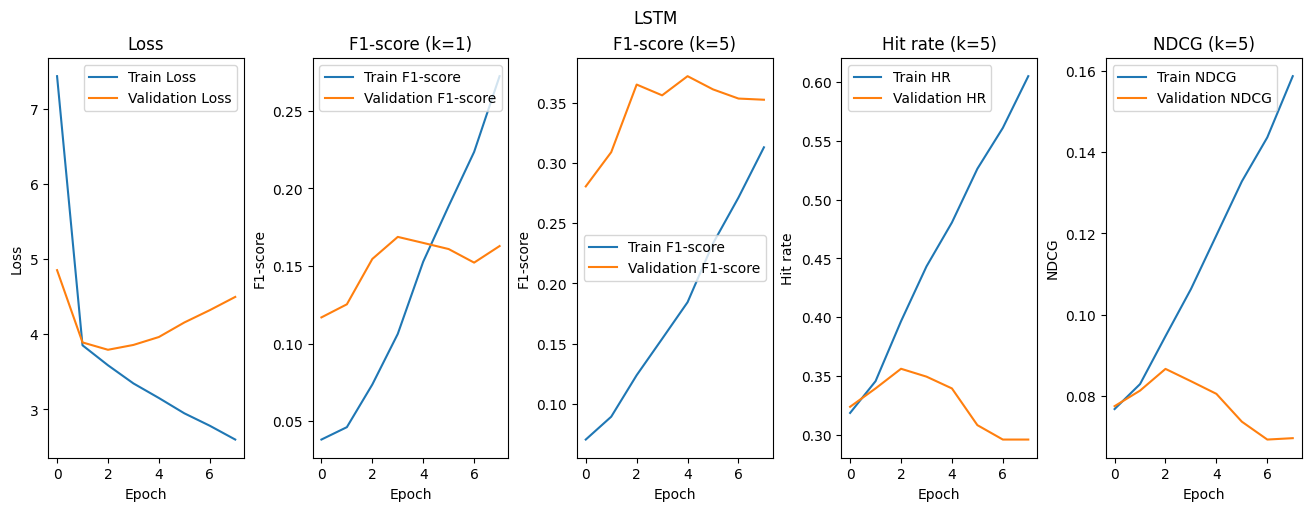

In [30]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('LSTM')
plt.show()

In [31]:
model_lstm_test_loss, model_lstm_test_accuracy, model_lstm_test_f1_score_k_1, model_lstm_test_f1_score_k_5, model_lstm_test_hr, model_lstm_test_ndcg = model_lstm.evaluate(test_dataset)

print("Test loss:", round(model_lstm_test_loss, 4))
print("Test accuracy:", round(model_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_lstm_test_ndcg, 4))

parameters["model_lstm_test_loss"] = model_lstm_test_loss
parameters["model_lstm_test_accuracy"] = round(model_lstm_test_accuracy, 4)
parameters["model_lstm_test_f1_score_k_1"] = round(model_lstm_test_f1_score_k_1, 4)
parameters["model_lstm_test_f1_score_k_5"] = round(model_lstm_test_f1_score_k_5, 4)
parameters["model_lstm_test_hr"] = round(model_lstm_test_hr, 4)
parameters["model_lstm_test_ndcg"] = round(model_lstm_test_ndcg, 4)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.1196 - f1_score: 0.1717 - f1_score_at_k: 0.3917 - hit_rate_at_k: 0.3156 - loss: 4.2374 - ndcg_at_k: 0.0745
Test loss: 4.6513
Test accuracy: 0.097
Test F1@1: 0.1358
Test F1@5: 0.3329
Test HR@5: 0.2679
Test NDCG@5: 0.0619


In [32]:
parameters

{'user': 'users-14',
 'user_id': 'A1HE5FWLYHKPQW',
 'number_of_sequences_and_targets_before_removal': 9046,
 'number_of_sequences_and_targets_after_removal': 8766,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 8672,
 'num_unique_product_ids_in_targets': 102,
 'num_unique_product_ids_in_sequences': 7849,
 'number_of_sequences_and_targets_train': 6927,
 'number_of_sequences_and_targets_validation': 869,
 'number_of_sequences_and_targets_test': 876,
 'number_of_unique_products_in_targets_train': 99,
 'number_of_unique_products_in_targets_validation': 100,
 'number_of_unique_products_in_targets_test': 102,
 'model_lstm_test_loss': 4.651252746582031,
 'model_lstm_test_accuracy': 0.097,
 'model_lstm_test_f1_score_k_1': 0.1358,
 'model_lstm_test_f1_score_k_5': 0.3329,
 'model_lstm_test_hr': 0.2679,
 'model_lstm_test_ndcg': 0.0619}

---------

## Bidirectional-LSTM

In [33]:
model_bi_lstm = Sequential()
model_bi_lstm.add(Embedding(input_dim=max_product_id, output_dim=50))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu', return_sequences=True)))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Bidirectional(LSTM(32, activation='relu')))
model_bi_lstm.add(BatchNormalization())
model_bi_lstm.add(Dropout(0.2))
model_bi_lstm.add(Dense(16, activation='relu'))
model_bi_lstm.add(Dense(max_product_id, activation='softmax'))

model_bi_lstm.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [34]:
history_model_bi_lstm = model_bi_lstm.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step - accuracy: 0.1026 - f1_score: 0.0337 - f1_score_at_k: 0.0663 - hit_rate_at_k: 0.2828 - loss: 9.5111 - ndcg_at_k: 0.0657 - val_accuracy: 0.1323 - val_f1_score: 0.1169 - val_f1_score_at_k: 0.2806 - val_hit_rate_at_k: 0.3237 - val_loss: 4.1671 - val_ndcg_at_k: 0.0774
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1386 - f1_score: 0.0471 - f1_score_at_k: 0.0842 - hit_rate_at_k: 0.3404 - loss: 3.8608 - ndcg_at_k: 0.0823 - val_accuracy: 0.1335 - val_f1_score: 0.1190 - val_f1_score_at_k: 0.2933 - val_hit_rate_at_k: 0.3203 - val_loss: 3.9240 - val_ndcg_at_k: 0.0774
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1454 - f1_score: 0.0635 - f1_score_at_k: 0.1137 - hit_rate_at_k: 0.3816 - loss: 3.6053 - ndcg_at_k: 0.0907 - val_accuracy: 0.1496 - val_f1_score: 0.1567 - val_f1_score_at_k: 0.3723 - val_hit_rate_at_k: 0.3672 - val_loss: 3.7736 - val_ndcg_at_k: 0.0877
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 7

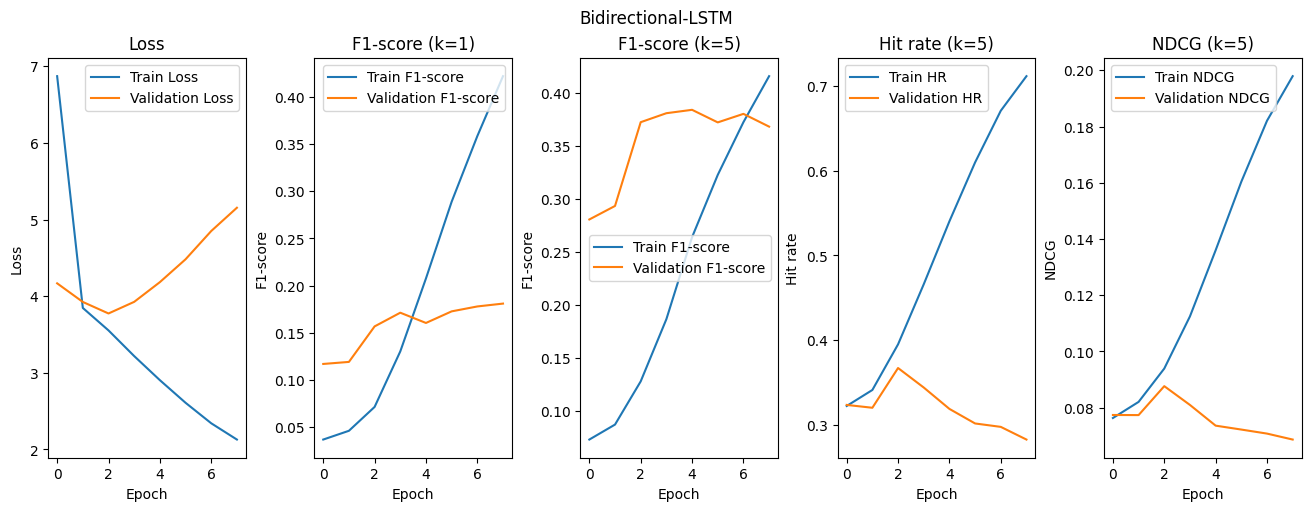

In [35]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_bi_lstm.history['loss'], label='Train Loss')
ax1.plot(history_model_bi_lstm.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_bi_lstm.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_bi_lstm.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_bi_lstm.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_bi_lstm.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_bi_lstm.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_bi_lstm.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_bi_lstm.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_bi_lstm.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Bidirectional-LSTM')
plt.show()

In [36]:
model_bi_lstm_test_loss, model_bi_lstm_test_accuracy, model_bi_lstm_test_f1_score_k_1, model_bi_lstm_test_f1_score_k_5, model_bi_lstm_test_hr, model_bi_lstm_test_ndcg = model_bi_lstm.evaluate(test_dataset)

print("Test loss:", round(model_bi_lstm_test_loss, 4))
print("Test accuracy:", round(model_bi_lstm_test_accuracy, 4))
print("Test F1@1:", round(model_bi_lstm_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_bi_lstm_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_bi_lstm_test_hr, 4))
print("Test NDCG@5:", round(model_bi_lstm_test_ndcg, 4))

parameters["model_bi_lstm_test_loss"] = model_bi_lstm_test_loss
parameters["model_bi_lstm_test_accuracy"] = round(model_bi_lstm_test_accuracy, 4)
parameters["model_bi_lstm_test_f1_score_k_1"] = round(model_bi_lstm_test_f1_score_k_1, 4)
parameters["model_bi_lstm_test_f1_score_k_5"] = round(model_bi_lstm_test_f1_score_k_5, 4)
parameters["model_bi_lstm_test_hr"] = round(model_bi_lstm_test_hr, 4)
parameters["model_bi_lstm_test_ndcg"] = round(model_bi_lstm_test_ndcg, 4)

28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.1098 - f1_score: 0.1693 - f1_score_at_k: 0.3903 - hit_rate_at_k: 0.2873 - loss: 4.9176 - ndcg_at_k: 0.0665
Test loss: 5.3228
Test accuracy: 0.1039
Test F1@1: 0.1565
Test F1@5: 0.3514
Test HR@5: 0.2619
Test NDCG@5: 0.0612


In [37]:
parameters

{'user': 'users-14',
 'user_id': 'A1HE5FWLYHKPQW',
 'number_of_sequences_and_targets_before_removal': 9046,
 'number_of_sequences_and_targets_after_removal': 8766,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 8672,
 'num_unique_product_ids_in_targets': 102,
 'num_unique_product_ids_in_sequences': 7849,
 'number_of_sequences_and_targets_train': 6927,
 'number_of_sequences_and_targets_validation': 869,
 'number_of_sequences_and_targets_test': 876,
 'number_of_unique_products_in_targets_train': 99,
 'number_of_unique_products_in_targets_validation': 100,
 'number_of_unique_products_in_targets_test': 102,
 'model_lstm_test_loss': 4.651252746582031,
 'model_lstm_test_accuracy': 0.097,
 'model_lstm_test_f1_score_k_1': 0.1358,
 'model_lstm_test_f1_score_k_5': 0.3329,
 'model_lstm_test_hr': 0.2679,
 'model_lstm_test_ndcg': 0.0619,
 'model_bi_lstm_test_loss': 5.322835922241211,
 'model_bi_lstm_test_accuracy': 0.1039,
 'model_bi_lstm_test_f1_score_k_1': 0.1565,
 '

-------

# GRU

In [38]:
model_gru = Sequential()
model_gru.add(Embedding(input_dim=max_product_id, output_dim=50))
model_gru.add(GRU(32, activation='relu', return_sequences=True))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(GRU(32, activation='relu'))
model_gru.add(BatchNormalization())
model_gru.add(Dropout(0.2))
model_gru.add(Dense(16, activation='relu'))
model_gru.add(Dense(max_product_id, activation='softmax'))

model_gru.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [39]:
history_model_gru = model_gru.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - accuracy: 0.1020 - f1_score: 0.0350 - f1_score_at_k: 0.0638 - hit_rate_at_k: 0.2793 - loss: 10.0471 - ndcg_at_k: 0.0651 - val_accuracy: 0.1323 - val_f1_score: 0.1169 - val_f1_score_at_k: 0.2806 - val_hit_rate_at_k: 0.3237 - val_loss: 4.4152 - val_ndcg_at_k: 0.0773
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1285 - f1_score: 0.0364 - f1_score_at_k: 0.0727 - hit_rate_at_k: 0.3327 - loss: 3.9240 - ndcg_at_k: 0.0790 - val_accuracy: 0.1289 - val_f1_score: 0.1190 - val_f1_score_at_k: 0.3026 - val_hit_rate_at_k: 0.3304 - val_loss: 3.9506 - val_ndcg_at_k: 0.0780
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.1517 - f1_score: 0.0650 - f1_score_at_k: 0.0962 - hit_rate_at_k: 0.3548 - loss: 3.6740 - ndcg_at_k: 0.0871 - val_accuracy: 0.1197 - val_f1_score: 0.1505 - val_f1_score_at_k: 0.3371 - val_hit_rate_at_k: 0.3259 - val_loss: 3.8657 - val_ndcg_at_k: 0.0767
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 1s 

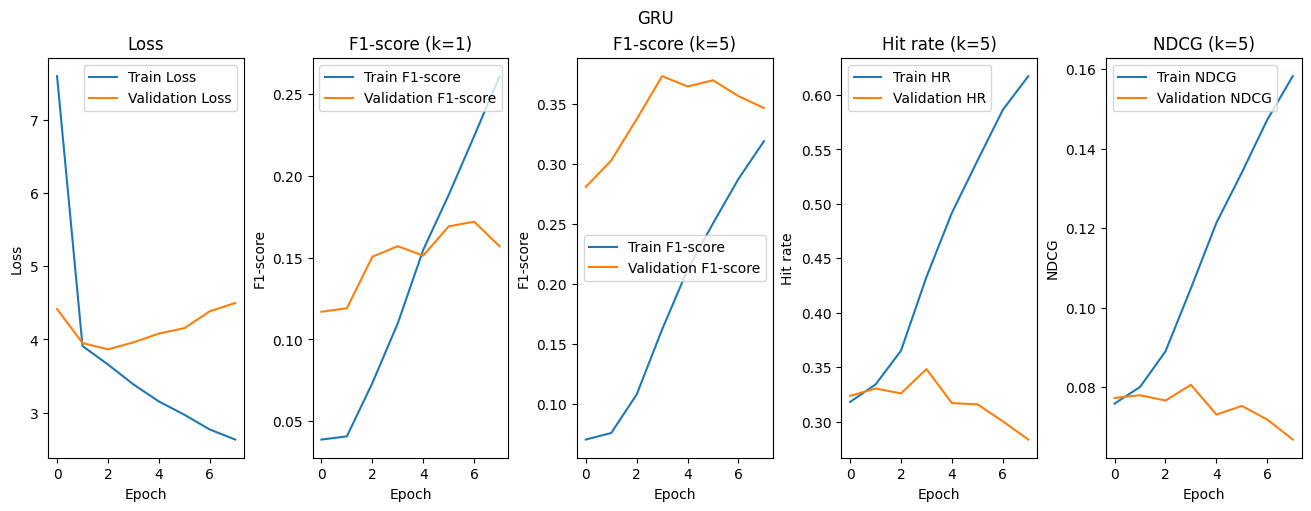

In [40]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_gru.history['loss'], label='Train Loss')
ax1.plot(history_model_gru.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_gru.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_gru.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_gru.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_gru.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_gru.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_gru.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_gru.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_gru.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('GRU')
plt.show()

In [41]:
model_gru_test_loss, model_gru_test_accuracy, model_gru_test_f1_score_k_1, model_gru_test_f1_score_k_5, model_gru_test_hr, model_gru_test_ndcg = model_gru.evaluate(test_dataset)

print("Test loss:", round(model_gru_test_loss, 4))
print("Test accuracy:", round(model_gru_test_accuracy, 4))
print("Test F1@1:", round(model_gru_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_gru_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_gru_test_hr, 4))
print("Test NDCG@5:", round(model_gru_test_ndcg, 4))

parameters["model_gru_test_loss"] = model_gru_test_loss
parameters["model_gru_test_accuracy"] = round(model_gru_test_accuracy, 4)
parameters["model_gru_test_f1_score_k_1"] = round(model_gru_test_f1_score_k_1, 4)
parameters["model_gru_test_f1_score_k_5"] = round(model_gru_test_f1_score_k_5, 4)
parameters["model_gru_test_hr"] = round(model_gru_test_hr, 4)
parameters["model_gru_test_ndcg"] = round(model_gru_test_ndcg, 4)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.1383 - f1_score: 0.2077 - f1_score_at_k: 0.4192 - hit_rate_at_k: 0.3462 - loss: 4.0474 - ndcg_at_k: 0.0814
Test loss: 4.5829
Test accuracy: 0.1119
Test F1@1: 0.1656
Test F1@5: 0.3463
Test HR@5: 0.2853
Test NDCG@5: 0.067


In [42]:
parameters

{'user': 'users-14',
 'user_id': 'A1HE5FWLYHKPQW',
 'number_of_sequences_and_targets_before_removal': 9046,
 'number_of_sequences_and_targets_after_removal': 8766,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 8672,
 'num_unique_product_ids_in_targets': 102,
 'num_unique_product_ids_in_sequences': 7849,
 'number_of_sequences_and_targets_train': 6927,
 'number_of_sequences_and_targets_validation': 869,
 'number_of_sequences_and_targets_test': 876,
 'number_of_unique_products_in_targets_train': 99,
 'number_of_unique_products_in_targets_validation': 100,
 'number_of_unique_products_in_targets_test': 102,
 'model_lstm_test_loss': 4.651252746582031,
 'model_lstm_test_accuracy': 0.097,
 'model_lstm_test_f1_score_k_1': 0.1358,
 'model_lstm_test_f1_score_k_5': 0.3329,
 'model_lstm_test_hr': 0.2679,
 'model_lstm_test_ndcg': 0.0619,
 'model_bi_lstm_test_loss': 5.322835922241211,
 'model_bi_lstm_test_accuracy': 0.1039,
 'model_bi_lstm_test_f1_score_k_1': 0.1565,
 '

-------

# Autoencoder

In [43]:
nn = [64, 32, 16, 32, 64]

model_autoencoder = Sequential()
model_autoencoder.add(Embedding(input_dim=max_product_id, output_dim=50))
model_autoencoder.add(Flatten())
model_autoencoder.add(Dense(units=nn[0], activation='relu'))
model_autoencoder.add(BatchNormalization())
model_autoencoder.add(Dropout(0.2))
for n in nn[1:]:
    model_autoencoder.add(Dense(units=n, activation='relu'))
    model_autoencoder.add(BatchNormalization())
    model_autoencoder.add(Dropout(0.2))
model_autoencoder.add(Dense(max_product_id, activation='softmax'))

model_autoencoder.compile(
    loss='sparse_categorical_crossentropy', 
    optimizer=Adam(learning_rate=0.001), 
    metrics=['accuracy', f1_score, f1_score_at_k, hit_rate_at_k, ndcg_at_k]
)

In [44]:
history_model_autoencoder = model_autoencoder.fit(
    train_dataset,
    epochs=50,
    batch_size=BATCH_SIZE,
    validation_data=val_dataset,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)]
)

Epoch 1/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 27s 59ms/step - accuracy: 0.0262 - f1_score: 0.0250 - f1_score_at_k: 0.0578 - hit_rate_at_k: 0.0896 - loss: 11.6009 - ndcg_at_k: 0.0196 - val_accuracy: 0.1323 - val_f1_score: 0.1169 - val_f1_score_at_k: 0.2462 - val_hit_rate_at_k: 0.2824 - val_loss: 5.9953 - val_ndcg_at_k: 0.0716
Epoch 2/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1317 - f1_score: 0.0573 - f1_score_at_k: 0.0923 - hit_rate_at_k: 0.3065 - loss: 5.5996 - ndcg_at_k: 0.0755 - val_accuracy: 0.1300 - val_f1_score: 0.1193 - val_f1_score_at_k: 0.2750 - val_hit_rate_at_k: 0.3069 - val_loss: 3.9268 - val_ndcg_at_k: 0.0750
Epoch 3/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.1423 - f1_score: 0.0646 - f1_score_at_k: 0.0946 - hit_rate_at_k: 0.3514 - loss: 3.8458 - ndcg_at_k: 0.0847 - val_accuracy: 0.1404 - val_f1_score: 0.1510 - val_f1_score_at_k: 0.3224 - val_hit_rate_at_k: 0.3371 - val_loss: 3.8593 - val_ndcg_at_k: 0.0812
Epoch 4/50
217/217 ━━━━━━━━━━━━━━━━━━━━ 2s 

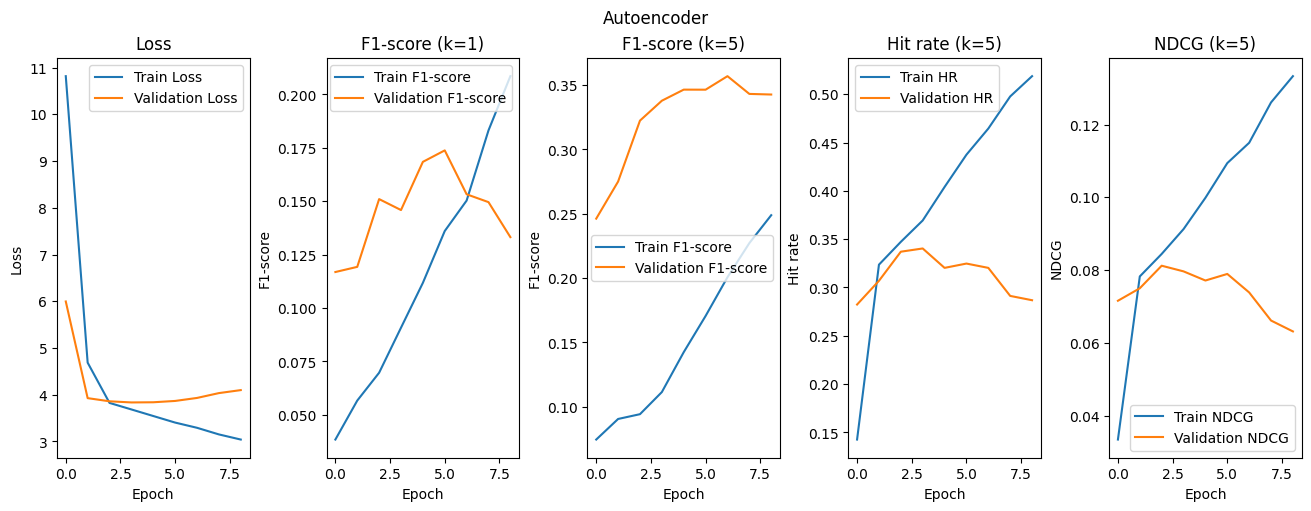

In [45]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(13, 5), constrained_layout=True)

plt.subplots_adjust(wspace=0.4)

ax1.plot(history_model_autoencoder.history['loss'], label='Train Loss')
ax1.plot(history_model_autoencoder.history['val_loss'], label='Validation Loss')
ax1.set_title('Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(history_model_autoencoder.history['f1_score'], label='Train F1-score')
ax2.plot(history_model_autoencoder.history['val_f1_score'], label='Validation F1-score')
ax2.set_title('F1-score (k=1)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('F1-score')
ax2.legend()

ax3.plot(history_model_autoencoder.history['f1_score_at_k'], label='Train F1-score')
ax3.plot(history_model_autoencoder.history['val_f1_score_at_k'], label='Validation F1-score')
ax3.set_title('F1-score (k=5)')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('F1-score')
ax3.legend()

ax4.plot(history_model_autoencoder.history['hit_rate_at_k'], label='Train HR')
ax4.plot(history_model_autoencoder.history['val_hit_rate_at_k'], label='Validation HR')
ax4.set_title('Hit rate (k=5)')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Hit rate')
ax4.legend()

ax5.plot(history_model_autoencoder.history['ndcg_at_k'], label='Train NDCG')
ax5.plot(history_model_autoencoder.history['val_ndcg_at_k'], label='Validation NDCG')
ax5.set_title('NDCG (k=5)')
ax5.set_xlabel('Epoch')
ax5.set_ylabel('NDCG')
ax5.legend()

plt.suptitle('Autoencoder')
plt.show()

In [46]:
model_autoencoder_test_loss, model_autoencoder_test_accuracy, model_autoencoder_test_f1_score_k_1, model_autoencoder_test_f1_score_k_5, model_autoencoder_test_hr, model_autoencoder_test_ndcg = model_autoencoder.evaluate(test_dataset)

print("Test loss:", round(model_autoencoder_test_loss, 4))
print("Test accuracy:", round(model_autoencoder_test_accuracy, 4))
print("Test F1@1:", round(model_autoencoder_test_f1_score_k_1, 4))
print("Test F1@5:", round(model_autoencoder_test_f1_score_k_5, 4))
print("Test HR@5:", round(model_autoencoder_test_hr, 4))
print("Test NDCG@5:", round(model_autoencoder_test_ndcg, 4))

parameters["model_autoencoder_test_loss"] = model_autoencoder_test_loss
parameters["model_autoencoder_test_accuracy"] = round(model_autoencoder_test_accuracy, 4)
parameters["model_autoencoder_test_f1_score_k_1"] = round(model_autoencoder_test_f1_score_k_1, 4)
parameters["model_autoencoder_test_f1_score_k_5"] = round(model_autoencoder_test_f1_score_k_5, 4)
parameters["model_autoencoder_test_hr"] = round(model_autoencoder_test_hr, 4)
parameters["model_autoencoder_test_ndcg"] = round(model_autoencoder_test_ndcg, 4)

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.1124 - f1_score: 0.1678 - f1_score_at_k: 0.3966 - hit_rate_at_k: 0.3182 - loss: 3.9139 - ndcg_at_k: 0.0738
Test loss: 4.1183
Test accuracy: 0.1039
Test F1@1: 0.1495
Test F1@5: 0.3407
Test HR@5: 0.2809
Test NDCG@5: 0.0649


In [47]:
parameters

{'user': 'users-14',
 'user_id': 'A1HE5FWLYHKPQW',
 'number_of_sequences_and_targets_before_removal': 9046,
 'number_of_sequences_and_targets_after_removal': 8766,
 'number_of_sequences_and_targets_after_dropping_duplicates_after_encoding': 8672,
 'num_unique_product_ids_in_targets': 102,
 'num_unique_product_ids_in_sequences': 7849,
 'number_of_sequences_and_targets_train': 6927,
 'number_of_sequences_and_targets_validation': 869,
 'number_of_sequences_and_targets_test': 876,
 'number_of_unique_products_in_targets_train': 99,
 'number_of_unique_products_in_targets_validation': 100,
 'number_of_unique_products_in_targets_test': 102,
 'model_lstm_test_loss': 4.651252746582031,
 'model_lstm_test_accuracy': 0.097,
 'model_lstm_test_f1_score_k_1': 0.1358,
 'model_lstm_test_f1_score_k_5': 0.3329,
 'model_lstm_test_hr': 0.2679,
 'model_lstm_test_ndcg': 0.0619,
 'model_bi_lstm_test_loss': 5.322835922241211,
 'model_bi_lstm_test_accuracy': 0.1039,
 'model_bi_lstm_test_f1_score_k_1': 0.1565,
 '

-----

#### Predicting target for the last sequence of the specific user

In [48]:
predicted_user = {
    'userID': last_user_sequence[0],
    'sequence': [encoding[last_user_sequence[2]], encoding[last_user_sequence[3]]],
    'target': encoding[last_user_sequence[1]]
}

predicted_user

{'userID': 'A1HE5FWLYHKPQW', 'sequence': [84582, 106862], 'target': 111985}

In [49]:
input_data = np.array([predicted_user['sequence']])
predictions = model_lstm.predict(input_data)

k_values = [5, 10, 20, 50, 100, 200, 300, 400, 500]

for k in k_values:
    hit_rate = hit_rate_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"HT@{k}: {hit_rate}")
    
    ndcg = ndcg_at_k(np.array([predicted_user['target']]), predictions, k=k).numpy()
    print(f"NDCG@{k}: {ndcg}")
    
    print("-------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
HT@5: 0.0
NDCG@5: 0.0
-------------
HT@10: 0.0
NDCG@10: 0.0
-------------
HT@20: 0.0
NDCG@20: 0.0
-------------
HT@50: 0.0
NDCG@50: 0.0
-------------
HT@100: 0.0
NDCG@100: 0.0
-------------
HT@200: 0.0
NDCG@200: 0.0
-------------
HT@300: 0.0
NDCG@300: 0.0
-------------
HT@400: 0.0
NDCG@400: 0.0
-------------
HT@500: 0.0
NDCG@500: 0.0
-------------
